このプログラフでは、構造の単純な格子状のグラフに対し、確率変化を辺のコストに与える

In [ ]:
import networkx as nx
from networkx import DiGraph
import matplotlib.pyplot as plt
from numpy import array
import numpy as np
from heapq import heappush, heappop
from itertools import count
import requests
import pprint
from heapdict import heapdict
import random

In [ ]:
def arrival_func(interval, velocity, distance): #Gの各辺に上記の変数を属性として持たせる関数
  n = len(interval)
  b = [] #その時点での経過時間
  a = [] #速度によって進む区間か止まる区間か1,0を乗算することで分ける
  for i,t in enumerate(interval): #iは何回目のループか tはそのループで計算する時間帯
    #待ちなしの場合
    b.append( interval[i] + distance[i]/velocity[i]) # start time + travel time
    a.append( 1 )       #aに1が存在する区間は速さに沿って進む 0のときは速さに0が乗算され,その場に留まる

  #待ちを表す区間の追加 それぞれのリスト末尾の要素を代入
  new_interval, new_b, new_a = [interval[n-1]],[b[n-1]],[a[n-1]]
  i = n-1             #このときiにはintervalの区間の数が代入される
  while True:
    for j in range(i-1,-1,-1):  #i-1から-1を含まない-1を差とする等差数列range
      T = b[i] - b[j]   
      #Tはi時に出発するコストとj時に出発するときのコストの差
      #もちろんjの方が時間帯としては早いため、b[j]の方が小さくTが負になるときは待った方が早いということ

      #print(i,j,T)
      if T < 0 :#iよりもjのほうが経過時間が長い.よって変更はjが始点以外はなし
          if j==0:#区間[0,1]の場合だけ待ち時間を追加
            new_interval.append( interval[j])
            new_b.append(b[i])
            new_a.append(0)
          continue
      if T ==0: #[j,i]を待ちに変換
          #待ちを表す傾き0区間を追加
          new_interval.append( interval[j] )
          new_b.append(b[i])
          new_a.append(0)
      elif T < interval[i]-interval[j]:#区間[j,i]で待ちをする
          #待ちを表す傾き0の区間を追加
          new_interval.append( interval[j]+T )
          new_b.append(b[i])
          new_a.append(0)
          #jで出発する区間を追加
          new_interval.append( interval[j] )
          new_b.append(b[j])
          new_a.append(1)
          break                                      #for文から抜ける
      else: #区間jをそのまま追加
          new_interval.append( interval[j] )
          new_b.append(b[j])
          new_a.append(1)
          break                                      #for文から抜ける
    #print("j=",j , new_interval)
    i = j
    if i ==0:
        break    #while文の終了
  new_interval.reverse() #それぞれのリストの要素を逆順にする操作
  new_b.reverse()
  new_a.reverse()
  return new_interval, new_b, new_a

In [ ]:
#export 関数の計算を行い値を求める #引数tは現在時刻を表す
def arrival(t, interval, b, a):
    flg = "FALSE"
    for i in range(len(interval)-1):
        if t>= interval[i] and t<interval[i+1]: #tが含まれる時間帯を発見
            flg ="TRUE"
            return b[i]+a[i]*(t-interval[i])

    if flg == "FALSE": #tがintervalに指定した数値を超えたまたは低い場合
            return b[-1]+(t-interval[-1])

In [ ]:
#export
def plot_arrival(interval, b, a):
    plt.figure()
    x =  np.arange(0.0, interval[-1]+5, 0.01)   #時間
    y = [ arrival(t,interval,b,a) for t in np.arange(0.0, interval[-1]+5, 0.01) ] #arrival関数
    plt.plot(x,y )
    return plt

変化する候補と確率を与えることで確率を加味した辺の重みが返される関数

変化候補のaとb そしてaが選ばれる確率xを引数とする

In [ ]:
def pNum(a, b, x):
  coin = random.random()

  if coin < x: #xの確率を満たすかどうか
    answer = a   #xの確率でaがanswerに
  else:
    answer = b   #1-xの確率でbがanswerに

  return answer


In [ ]:
G = nx.Graph()
G.add_weighted_edges_from(
    [("s", 1, [pNum(100, 200, 0.8), pNum(100, 200, 0.8), pNum(100, 200, 0.8)]), ("s", 3, [pNum(100, 200, 0.8), pNum(100, 200, 0.8), pNum(100, 200, 0.8)]),
     (1, 2, [pNum(100, 200, 0.8), pNum(100, 200, 0.8), pNum(100, 200, 0.8)]), (1, 4, [pNum(100, 200, 0.8), pNum(100, 200, 0.8), pNum(100, 200, 0.8)]),
     (2, 5, [pNum(100, 200, 0.8), pNum(100, 200, 0.8), pNum(100, 200, 0.8)]),
     (3, 4, [pNum(100, 200, 0.8), pNum(100, 200, 0.8), pNum(100, 200, 0.8)]), (3, 6, [pNum(100, 200, 0.8), pNum(100, 200, 0.8), pNum(100, 200, 0.8)]),
     (4, 5, [pNum(100, 200, 0.8), pNum(100, 200, 0.8), pNum(100, 200, 0.8)]), (4, 7, [pNum(100, 200, 0.8), pNum(100, 200, 0.8), pNum(100, 200, 0.8)]),
     (5, "t", [pNum(100, 200, 0.8), pNum(100, 200, 0.8), pNum(100, 200, 0.8)]),
     (6, 7, [pNum(100, 200, 0.8), pNum(100, 200, 0.8), pNum(100, 200, 0.8)]),
     (7, "t", [pNum(100, 200, 0.8), pNum(100, 200, 0.8), pNum(100, 200, 0.8)])] #グラフGの頂点と辺のコストの設定
)
Vlist = G.nodes     #頂点集合V(G)を定義する
Slist = []          #集合Sの初期化
interval = [0, 1, 2]  # time interval ここでの0時とは開始時点の時刻のこと
velocity = [300, 300, 300]  # velocity
for (i, j) in G.edges():
  #piecewiseという属性に値を持たせておくイメージ
    G[i][j]["piecewise"] = arrival_func(interval, velocity, distance=G[i][j]["weight"]) 

In [ ]:
Vlist = G.nodes
print(Vlist)

['s', 1, 3, 2, 4, 5, 6, 7, 't']


In [ ]:
"""
G.add_weighted_edges_from(
    [("s", 1, 100), ("s", 3, 100),
     (1, 2, 100), (1, 4, 100),
     (2, 5, 100),
     (3, 4, 100), (3, 6, 100),
     (4, 5, 100), (4, 7, 100),
     (5, "t", 100),
     (6, 7, 100),
     (7, "t", 100)] #グラフGの頂点と辺のコストの設定
)


G = nx.Graph()
G.add_weighted_edges_from(
    [("s", 1, [100, 200, 300]), ("s", 3, [100, 200, 300]),
     (1, 2, [100, 200, 300]), (1, 4, [100, 200, 300]),
     (2, 5, [100, 200, 300]),
     (3, 4, [100, 200, 300]), (3, 6, [100, 200, 300]),
     (4, 5, [100, 200, 300]), (4, 7, [100, 200, 300]),
     (5, "t", [100, 200, 300]),
     (6, 7, [100, 200, 300]),
     (7, "t", [100, 200, 300])] #グラフGの頂点と辺のコストの設定
)

G.add_weighted_edges_from(
    [("s", 1, [pNum(100, 200, 0.8), pNum(100, 200, 0.8)]), ("s", 3, [pNum(100, 200, 0.8), pNum(100, 200, 0.8)]),
     (1, 2, [pNum(100, 200, 0.8), pNum(100, 200, 0.8)]), (1, 4, [pNum(100, 200, 0.8), pNum(100, 200, 0.8)]),
     (2, 5, [pNum(100, 200, 0.8), pNum(100, 200, 0.8)]),
     (3, 4, [pNum(100, 200, 0.8), pNum(100, 200, 0.8)]), (3, 6, [pNum(100, 200, 0.8), pNum(100, 200, 0.8)]),
     (4, 5, [pNum(100, 200, 0.8), pNum(100, 200, 0.8)]), (4, 7, [pNum(100, 200, 0.8), pNum(100, 200, 0.8)]),
     (5, "t", [pNum(100, 200, 0.8), pNum(100, 200, 0.8)]),
     (6, 7, [pNum(100, 200, 0.8), pNum(100, 200, 0.8)]),
     (7, "t", [pNum(100, 200, 0.8), pNum(100, 200, 0.8)])] #グラフGの頂点と辺のコストの設定
)
"""

グラフGの形を表示する

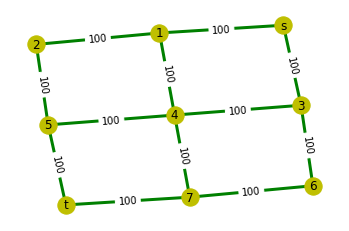

In [ ]:
edge_labels = {}
pos = nx.kamada_kawai_layout(G)
for (i, j) in G.edges():
    edge_labels[i, j] = f"{ G[i][j]['weight'] }"
nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)
nx.draw(
    G, node_size=300, pos=pos, node_color="y", edge_color="g", width=3, with_labels=True
)
plt.show()

s 1
s 3
1 2
1 4
3 4
3 6
2 5
4 5
4 7
5 t
6 7
7 t


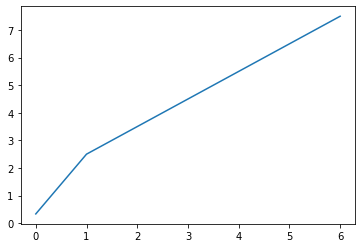

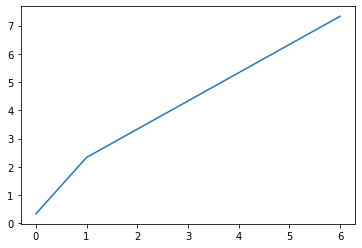

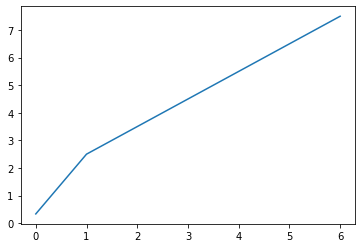

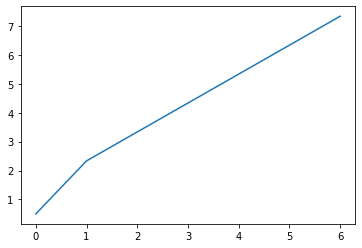

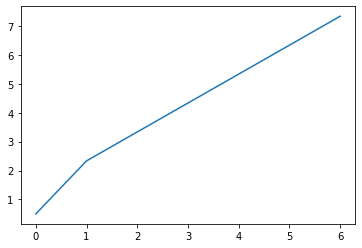

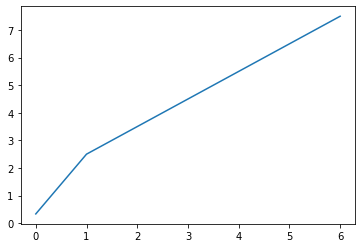

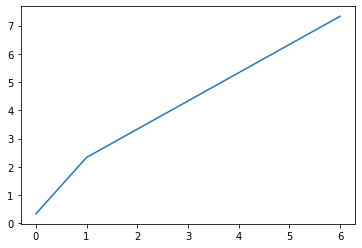

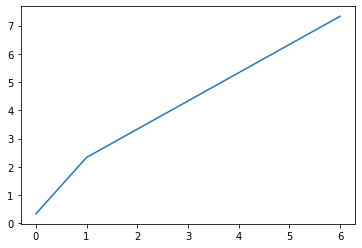

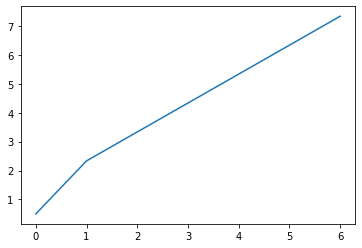

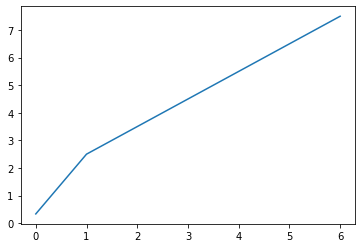

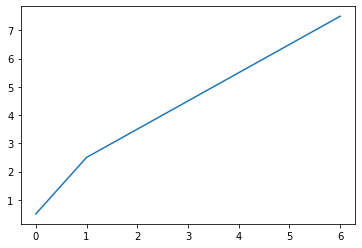

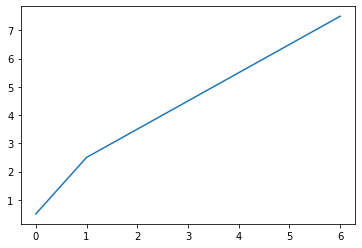

In [ ]:
for (i, j) in G.edges:
    interval, b, a = G[i][j]["piecewise"]
    print(i,j)
    plot_arrival(interval, b, a)

In [ ]:
#ここでのu,vは頂点のこと(u,v)は辺を表す

source = "s"  #始点
target = "t"  #終点
G_succ = G.succ if G.is_directed() else G.adj#G.有向グラフならG.succが代入され、それ以外はG.adjが代入
pred = {source: []}  #頂点における最短経路の一つ前の頂点を記録する辞書
paths = {source: [source]} #その頂点までの経路を格納する辞書

push = heappush
pop = heappop
dist = {}  # dictionary of final distances #頂点における最短コスト
seen = {source: 0}  #現時点でのその頂点の最短コストを格納する辞書
c = count() #要素ごとの出現回数 今回はcが出てくるたびに1増えていく
fringe = []  # use heapq with (distance,label) tuples
push(fringe, (0, next(c), source)) #優先度付きキューとしてfringeにタプル、要素の組を挿入
                                  # 最短コスト,順番にfringeに要素を代入するための指標、どの頂点の組なのか

#ここからダイクストラ法の実行が始まる
while fringe: #breakするまでループし続ける
    (d, _, v) = pop(fringe) #popで取り出されるのは最小値のため、dは頂点に記録された最短コスト、vは頂点vであるということ
    Slist.append(v)       #集合Sに頂点vを格納する
    if v in dist:             #始点となるvがリストdistに入っていればTRUE
        continue  # already searched this node.
    dist[v] = d      #頂点Vの最短コストにdを代入する
    if set(Slist) == set(Vlist):  #すべての頂点が集合Sに格納されたらwhileループは終了
        break

    for u, e in G_succ[v].items():   #G_succに格納されたv点から出ていく方向の辺と属性
        interval, b, a = G[v][u]["piecewise"]
        vu_dist = arrival(dist[v], interval, b, a)   #vu_distにはvu間のコストが入る
        if u in dist:
            if vu_dist < dist[u]:
                raise ValueError("Contradictory paths found:", "negative weights?")
        elif u not in seen or vu_dist < seen[u]:   #seenに既に
            seen[u] = vu_dist
            push(fringe, (vu_dist, next(c), u))
            if paths is not None:  #その頂点までの道が定義されていない場合、定義する
                paths[u] = paths[v] + [u]
            if pred is not None:  #以降はp[v]の再定義を行う部分
                pred[u] = [v]
        elif vu_dist == seen[u]:
            if pred is not None:
                pred[u].append(v)
print(pred)    #predには最短経路でその頂点に入る方向の辺の片側の点情報
print(dist)    #distには頂点の最短コストが格納される

{'s': [], 1: ['s'], 3: ['s'], 2: [1], 4: [3], 6: [3], 5: [2, 4], 7: [4], 't': [5, 7]}
{'s': 0, 1: 0.3333333333333333, 3: 0.3333333333333333, 2: 0.6666666666666666, 4: 0.6666666666666666, 6: 0.6666666666666666, 5: 1.0, 7: 1.0, 't': 2.3333333333333335}


In [ ]:
for i in pred:
  if i == "t":
    print(i)
    print(dist[i])
    while 1:
      print("↑")
      print(pred[i])
      i = pred[i]
      i = i[0]
      print(dist[i])

      if i == "s":
        break

t
2.6666666666666665
↑
[5]
1.1666666666666665
↑
[2]
0.8333333333333333
↑
[1]
0.5
↑
['s']
0


In [ ]:
G = nx.Graph()
G.add_weighted_edges_from(
    [("s", 1, [100, 200, 300]), ("s", 3, 100),
     (1, 2, 100), (1, 4, 100),
     (2, 5, 100),
     (3, 4, 100), (3, 6, 100),
     (4, 5, 100), (4, 7, 100),
     (5, "t", 100),
     (6, 7, 100),
     (7, "t", 100)] #グラフGの頂点と辺のコストの設定
)

In [ ]:
distance=G["s"][1]["weight"]

In [ ]:
distance

[100, 200, 300]

In [ ]:
print(pNum(1, 2, 0.5))

2


確率を扱うため、何回か探索を繰り返し、算出された経路が確率を考えたうえでの最短経路であると言える

In [ ]:
import networkx as nx
from networkx import DiGraph
import matplotlib.pyplot as plt
from numpy import array
import numpy as np
from heapq import heappush, heappop
from itertools import count
import requests
import pprint
from heapdict import heapdict
import random

In [ ]:
routelist = [0]
countlist = 101*[0]  
answerlist = 101*[0]
sumdist = {}
appearList = {}

loop = 10000  #ループさせる回数

for _ in range(loop):

  G = nx.Graph()
  G.add_weighted_edges_from(
    [("s", 1, [pNum(100, 200, 0.8), pNum(100, 200, 0.8)]), ("s", 3, [pNum(100, 200, 0.8), pNum(100, 200, 0.8)]), ("s", 5, [pNum(100, 200, 0.8), pNum(100, 200, 0.8)]), ("s", 7, [pNum(100, 200, 0.8), pNum(100, 200, 0.8)]),
     (1, 2, [pNum(78.5, 157, 0.8), pNum(78.5, 157, 0.8)]), (1, 8, [pNum(78.5, 157, 0.8), pNum(78.5, 157, 0.8)]), (1, 9, [pNum(100, 200, 0.8), pNum(100, 200, 0.8)]),
     (2, 3, [pNum(78.5, 157, 0.8), pNum(78.5, 157, 0.8)]), (2, 10, [pNum(100, 200, 0.8), pNum(100, 200, 0.8)]),
     (3, 4, [pNum(78.5, 157, 0.8), pNum(78.5, 157, 0.8)]), (3, 11, [pNum(100, 200, 0.8), pNum(100, 200, 0.8)]),
     (4, 5, [pNum(78.5, 157, 0.8), pNum(78.5, 157, 0.8)]), (4, 12, [pNum(100, 200, 0.8), pNum(100, 200, 0.8)]),
     (5, 6, [pNum(78.5, 157, 0.8), pNum(78.5, 157, 0.8)]), (5, 13, [pNum(100, 200, 0.8), pNum(100, 200, 0.8)]),
     (6, 7, [pNum(78.5, 157, 0.8), pNum(78.5, 157, 0.8)]), (6, 14, [pNum(100, 200, 0.8), pNum(100, 200, 0.8)]),
     (7, 8, [pNum(78.5, 157, 0.8), pNum(78.5, 157, 0.8)]), (7, 15, [pNum(100, 200, 0.8), pNum(100, 200, 0.8)]),
     (8, "t", [pNum(100, 200, 0.8), pNum(100, 200, 0.8)]),
     (9, 10, [pNum(157, 314, 0.8), pNum(157, 314, 0.8)]), (9, "t", [pNum(157, 314, 0.8), pNum(157, 314, 0.8)]),
     (10, 11, [pNum(157, 314, 0.8), pNum(157, 314, 0.8)]),
     (11, 12, [pNum(157, 314, 0.8), pNum(157, 314, 0.8)]),
     (12, 13, [pNum(157, 314, 0.8), pNum(157, 314, 0.8)]),
     (13, 14, [pNum(157, 314, 0.8), pNum(157, 314, 0.8)]),
     (14, 15, [pNum(157, 314, 0.8), pNum(157, 314, 0.8)]),
     (15, "t", [pNum(157, 314, 0.8), pNum(157, 314, 0.8)])] #グラフGの頂点と辺のコストの設定
  )


  Vlist = G.nodes     #頂点集合V(G)を定義する
  Slist = []          #集合Sの初期化
  interval = [0, 60]  # time interval ここでの0時とは開始時点の時刻のこと
  velocity = [300, 300]  # velocity

  for (i, j) in G.edges():
  #piecewiseという属性に値を持たせておくイメージ
    G[i][j]["piecewise"] = arrival_func(interval, velocity, distance=G[i][j]["weight"])

   
  #ここでのu,vは頂点のこと(u,v)は辺を表す

  source = "s"  #始点
  target = "t"  #終点
  G_succ = G.succ if G.is_directed() else G.adj#G.有向グラフならG.succが代入され、それ以外はG.adjが代入
  pred = {source: []}  #頂点における最短経路の一つ前の頂点を記録するリスト
  paths = {source: [source]} #

  push = heappush
  pop = heappop
  dist = {}  # dictionary of final distances #頂点における最短コスト
  seen = {source: 0}
  c = count() #要素ごとの出現回数 今回はcが出てくるたびに1増えていく
  fringe = []  # use heapq with (distance,label) tuples
  push(fringe, (0, next(c), source))

  #ここからダイクストラ法の実行が始まる
  while fringe: #breakするまでループし続ける
    (d, _, v) = pop(fringe) #dは頂点に記録された最短コスト、vは頂点vであるということ
    Slist.append(v)
    if v in dist:             #始点となるvがリストdistに入っていれば次のwhileに
        continue  # already searched this node.
    dist[v] = d      #頂点Vの最短コストを決定する

    if v in appearList:   #vがdistに代入されたらカウントする
      emp = appearList[v]
      appearList[v] = emp + 1
    else:
      appearList[v] = 1

    if v in sumdist:
      emp = sumdist[v]
      sumdist[v] = emp + d
    else:
      sumdist[v] = d

    if set(Slist) == set(Vlist):  #ゴールに辿り着くとwhileループは終了
        break

    for u, e in G_succ[v].items():   #G_succに格納されたv点から出ていく方向の辺と属性
        interval, b, a = G[v][u]["piecewise"]
        vu_dist = arrival(dist[v], interval, b, a)   #vu_distにはvu間のコストが入る
        if u in dist:
           if vu_dist < dist[u]:
                raise ValueError("Contradictory paths found:", "negative weights?")
        elif u not in seen or vu_dist < seen[u]:
            seen[u] = vu_dist
            push(fringe, (vu_dist, next(c), u))
            if paths is not None:
                 paths[u] = paths[v] + [u]
            if pred is not None:
                pred[u] = [v]
        elif vu_dist == seen[u]:
            if pred is not None:
                pred[u].append(v)


  for i in pred: #経路を一つの変数に結合する
    if i == "t":
      route = str(i)  #routeには今回の試行の経路を保存する 値の初期化の意味もある
      while 1:
        route += "←"
        route += str(pred[i]) #経路を文字列に変換して結合していく
        i = pred[i]
        i = i[0]

        if i == "s":
            break

  judgment = "FALSE"
  for cn, _ in enumerate(routelist):
    if route == routelist[cn]:
      countlist[cn] += 1   #リスト内に既に同じ経路が存在した場合算出された回数をカウントする
      answerlist[cn] += dist["t"]
      judgment = "TRUE" 
      break

  if judgment == "FALSE":
    routelist.append(route)  #routelist内に存在しないため新たに経路を保存する
    countlist[cn+1] += 1
    answerlist[cn+1] += dist["t"]

#ここから結果の整理を行う

maxCount = max(countlist)  #最も算出された経路の回数を取得
max_index = np.argmax(countlist)  #countlistで最も大きい値の添え字を得る

maxRoute = routelist[max_index]  #その添え字のroutelistの経路が最も最短であったということ
percent = maxCount/loop

print("最も最短である確率が高いのは")
print(maxRoute)

print("今回の試行でこの経路が算出された割合は")
print(percent)

print("この経路における最短コストの平均は")
#print(answerlist)
print(answerlist[max_index]/maxCount)

print("それぞれの頂点の最短コスト平均")
for key in sumdist.keys():
  sum = sumdist[key]
  cn = appearList[key]
  sumdist[key] = round(sum/loop, 4) #sumdistに格納された値をloopの値で平均をとる

print(sumdist) #それぞれの頂点の最短コストが表示される

最も最短である確率が高いのは
t←[8]←[1, 7]←['s']
今回の試行でこの経路が算出された割合は
0.3641
この経路における最短コストの平均は
0.9619362812413874
それぞれの頂点の最短コスト平均
{'s': 0.0, 1: 0.4005, 3: 0.3993, 7: 0.3982, 2: 0.6314, 8: 0.6317, 4: 0.6317, 6: 0.6308, 5: 0.4023, 11: 0.7995, 15: 0.7972, 12: 1.0166, 9: 0.8011, 10: 1.0183, 14: 1.0162, 't': 1.0189, 13: 0.8036}


In [ ]:
dist

{'s': 0,
 1: 0.3333333333333333,
 3: 0.3333333333333333,
 5: 0.3333333333333333,
 7: 0.3333333333333333,
 2: 0.595,
 4: 0.595,
 6: 0.595,
 8: 0.595,
 9: 0.6666666666666666,
 11: 0.6666666666666666,
 13: 0.6666666666666666,
 15: 0.6666666666666666,
 10: 0.9283333333333332,
 12: 0.9283333333333332,
 14: 0.9283333333333332,
 16: 0.9283333333333332,
 17: 1.0,
 19: 1.0,
 21: 1.0,
 18: 1.2616666666666665,
 20: 1.2616666666666665,
 22: 1.2616666666666665,
 23: 1.3333333333333333,
 't': 1.5949999999999998}

In [ ]:
dist

{'s': 0,
 1: 0.3333333333333333,
 3: 0.3333333333333333,
 5: 0.3333333333333333,
 2: 0.595,
 4: 0.595,
 7: 0.6666666666666666,
 9: 0.6666666666666666,
 11: 0.6666666666666666,
 13: 0.6666666666666666,
 8: 0.8566666666666667,
 6: 0.8566666666666667,
 10: 0.9283333333333332,
 15: 1.0,
 17: 1.0,
 19: 1.0,
 21: 1.0,
 16: 1.19,
 14: 1.19,
 18: 1.2616666666666665,
 12: 1.2616666666666667,
 23: 1.3333333333333333,
 22: 1.5233333333333332,
 't': 1.8566666666666665}

ある1つの頂点を端点に持つ辺のコストが増加する確率を大きくする

この操作をすべての頂点に行うことで、ゴールまでの経路の中で頂点の重要度や点と点のど関係性などが見えてくるはず

In [ ]:
for key in sumdist.keys():
  print(key)

s
3
1
4
6
2
7
5
t


最短経路のコスト平均を表示できるようにしてもよいかも

In [ ]:
print(countlist)

[0, 10, 9, 3, 11, 5, 5, 7, 5, 10, 3, 6, 5, 2, 2, 1, 1, 3, 1, 4, 2, 1, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
li = [0, 1, 2, 3]

il = [0, 1, 2, 3]

if li == il:
  print("same")

same


In [ ]:
i = 0

hon = [1, 2]

s = str(hon[i])

print(type(s))

<class 'str'>


In [ ]:
routelist = [0,2]

for i , _ in enumerate(routelist):
  print(i)


0
1


In [ ]:
routelist = [0]
countlist = 101*[0]  #動作のためにループ数の1足した数用意する

route = "afaw"

judgment = "FALSE"
for i, _ in enumerate(routelist):
  if route == routelist[i]:
     countlist[i] += 1   #リスト内に既に同じ経路が存在した場合算出された回数をカウントする
     judgment = "TRUE" 
     break

if judgment == "FALSE":
   routelist.append(route)  #routelist内に存在しないため新たに経路を保存する
   countlist[i+1] += 1
print(routelist)
print(countlist)

[0, 'afaw']
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


グラフの形を保存しておく場所